# Processing AIS Logs

## Summary

This chapter will cover how to extract information about the course and track of **other** boats and display alongside our internal logs.

[Automatic Identification System](https://en.wikipedia.org/wiki/Automatic_identification_system) (AIS): *AIS integrates a standardized VHF transceiver with a positioning system such as a Global Positioning System receiver, with other electronic navigation sensors, such as a gyrocompass or rate of turn indicator.*  Typically messages including lat/lon/COG/SOG are sent every 30 seconds.

[Maritime Mobile Service Identity](https://en.wikipedia.org/wiki/Maritime_Mobile_Service_Identity) (MMSI): *A Maritime Mobile Service Identity (MMSI) is a series of nine digits which are sent in digital form over a radio frequency channel in order to uniquely identify ship stations, ship earth stations, coast stations, coast earth stations, and group calls.*

Below is an image of a sail track extracted from the AIS logs.

![im](Data/Images/ais_chart.png)


## Setup

Recently did a tune up match versus another boat.  Both boats typically upload to RaceQs, and later using RaceQs mapping and replay features we can get a better sense of who was sailing higher and/or faster.  But this time the other boat had a technical issue and **could not run RaceQs**.

I was a bit sad to miss out on this data, but then it hit me.  We have data on the other boat in our logs, specifically because they use an AIS transponder.

Note, I currently "run" RaceQs by processing the Canboat logs and then generating a GPX file.  I upload this GPX file to the RaceQs site, and it works great. I do not run the RaceQs app.  Its been a bit unreliable, and it is limited by the quality of the GPS in my phone.  Since I am using the GPS on my boat instead (which has a receiver the size of my fist), I get much higher quality tracks and it is much more reliable. In principle, I could do the same for another boat, as long as I had information about lat/lon versus time.

One of the devices on my NMEA network is a fancy [V50 B&G Radio](https://www.bandg.com/bg/type/vhf-ais/vhf-marine-radiov50/).  The V50 handles sending and receiving of AIS messages.  It sends these AIS fixes over NMEA 2k to my chartplotter and they magically appear (in an annoying BandG interface).

Because we log every NMEA 2K message, AIS fixes are part of my log, **for every boat that is using AIS within range.**

There are 4 AIS messages that I've seen on my 2K network:

            (129039, "AIS Class B Position Report"),
            (129809, "AIS Class B static data (msg 24 Part A)"),
            (129810, "AIS Class B static data (msg 24 Part B)"),
            (130842, "Simnet: AIS Class B static data (msg 24 Part A)")

PGN 130842 seems to be a duplicate of 129809 and 129810 (I suspect this is a BandG thing, since BandG merged with Simrad).  

Most info is sent in **PGN 129039**.  These appear every 30 seconds or so, and include lat/lon/COG/SOG:

    {"timestamp":"2020-04-01T12:15:30.816Z","prio":4,"src":8,"dst":255,"pgn":129039,"description":"AIS Class B Position Report","fields":{"Message ID":18,"Repeat Indicator":"Initial","User ID":338056811,"Longitude":-122.4130630,"Latitude":47.6858215,"Position Accuracy":"High","RAIM":"in use","Time Stamp":"4","COG":242.4,"SOG":3.24,"Communication State":"3","AIS Transceiver information":"Channel B VDL reception","Regional Application":0,"Regional Application":0,"Unit type":"CS","Integrated Display":"Yes","DSC":"Yes","Band":"entire marine band","Can handle Msg 22":"Yes","AIS mode":"Assigned","AIS communication state":"ITDMA"}}

Note, there is no GPS timestamp nor info on the **name** of the boat, just the `User ID` which turns out to be the.  (The timestamp is from the RPi and it is wrong.)

Info on the craft name is in **PGN 129809**:

    {"timestamp":"2020-04-01T12:22:52.186Z","prio":6,"src":8,"dst":255,"pgn":129809,"description":"AIS Class B static data (msg 24 Part A)","fields":{"Message ID":24,"Repeat indicator":"Initial","User ID":338056811,"Name":"CREATIVE"}}

Info on craft size is in **PGN 129810**.  This is super helpful when avoiding container ships and cruise liners, not useful for racing.

    {"timestamp":"2020-04-01T12:23:03.273Z","prio":6,"src":8,"dst":255,"pgn":129810,"description":"AIS Class B static data (msg 24 Part B)","fields":{"Message ID":24,"Repeat indicator":"Initial","User ID":338056811,"Type of ship":"Sailing","Vendor ID":"}BT  ","Callsign":"","Length":10.0,"Beam":4.0,"Position reference from Starboard":3.0,"Position reference from Bow":4.0,"Mothership User ID":0,"Spare":0}}

## Challenges

1. Retrieving the correct set of records based on craft name of MMSI (aka User ID).
1. Getting GPS time for the lat/lon fixes.
1. Converting to Pandas.
1. Writing the GPX file.

We will focus on two AIS messages:

    (129039, "AIS Class B Position Report"),
    (129809, "AIS Class B static data (msg 24 Part A)"),
    
The first has lat/lon and timing, the second craft name.  In addition we will extract GPS time from:

    (129029, 'GNSS Position Data'),
    
We'll collect all the messages of each type and stuff them into two different dataframes.  The only trick is to get the correct times.  We'll do a "best effort" job and simply capture the most recent GPS time message and use it to determine the GPS time as well as the (incorrect) system time.  (Recall that the system time, aka RPi time, is not correct.)


In [1]:
# Load some libraries
%matplotlib notebook

import logging
import copy
import itertools as it

import numpy as np
import scipy
import scipy.interpolate
import pandas as pd
import arrow

import global_variables
G = global_variables.init_seattle()

import canboat as cb
import chart as c
import process as p

PGN_GNSS         = cb.pgn_code('GNSS Position Data')
PGN_AIS_POSITION = 129039  # AIS Class B Position Report
PGN_AIS_DATA     = 129809  # AIS Class B static data (msg 24 Part A)

In [2]:
def ais_dataframes(records):
    "Return two dataframes, one that records the positions of all AIS craft.  The second that records the names."
    pgns_to_collect = {PGN_AIS_POSITION, PGN_AIS_DATA}
    pgn_rows = {k:[] for k in pgns_to_collect}
    gnss_datetime = None
    for record_num, record in zip(it.count(), records):
        if record_num % 200000 == 0:
            logging.info(f"Processed {record_num} json lines.")
        pgn = record['pgn']
        if pgn == PGN_GNSS:
            gnss_timestamp = arrow.get(record['timestamp'])
            gnss_datetime = cb.convert_gnss_date_time(record['fields']['Date'],
                                                      record['fields']['Time'])
        elif pgn in pgns_to_collect and gnss_datetime is not None:
            # Wait until we've seen at least one GNSS message
            row = copy.copy(record['fields'])
            timestamp = arrow.get(record['timestamp']).datetime
            row['timestamp'] = timestamp
            delta_time = timestamp - gnss_timestamp
            gps_datetime = gnss_datetime + delta_time
            row['gnss_datetime'] = gnss_datetime
            row['row_times'] = gps_datetime.datetime
            pgn_rows[pgn].append(row)
    res = {}
    for pgn, rows in pgn_rows.items():
        df = pd.DataFrame(rows)
        df = df.rename(columns=cb.canonical_field_name)
        res[pgn] = df
    return res

def json_to_ais_data_frame(json_file, max_rows=None):
    "Read the JSON log file and produce a dataframe contains all lat/lon fixes contained in the AIS logs."
    records = cb.json_records( cb.file_lines(json_file), None, 1)
    records = it.islice(records, 0, max_rows)

    dfs = ais_dataframes(records)

    df_pos = dfs[PGN_AIS_POSITION]
    df_data = dfs[PGN_AIS_DATA][['user_id', 'name']].drop_duplicates()
    df_joined = df_pos.merge(df_data, on='user_id')
    return df_joined


In [3]:
json_path = p.json_from_matching_named_file("2020-04-12")
df = json_to_ais_data_frame(json_path, None) # 100000)
df_creative = df[df.name=='CREATIVE']

2020-04-14 22:09:56,994|INFO|json_from_named_file| 2020-04-12_10:29.log.gz: Creating JSON
2020-04-14 22:09:56,996|INFO|json_from_named_file| File /tmp/2020-04-12_10:29.json exists, skipping.
2020-04-14 22:09:56,997|INFO|ais_dataframes| Processed 0 json lines.
2020-04-14 22:09:58,704|INFO|ais_dataframes| Processed 200000 json lines.
2020-04-14 22:10:00,408|INFO|ais_dataframes| Processed 400000 json lines.
2020-04-14 22:10:02,169|INFO|ais_dataframes| Processed 600000 json lines.
2020-04-14 22:10:03,908|INFO|ais_dataframes| Processed 800000 json lines.
2020-04-14 22:10:05,665|INFO|ais_dataframes| Processed 1000000 json lines.
2020-04-14 22:10:07,512|INFO|ais_dataframes| Processed 1200000 json lines.
2020-04-14 22:10:09,275|INFO|ais_dataframes| Processed 1400000 json lines.
2020-04-14 22:10:11,068|INFO|ais_dataframes| Processed 1600000 json lines.
2020-04-14 22:10:12,785|INFO|ais_dataframes| Processed 1800000 json lines.


<IPython.core.display.Javascript object>


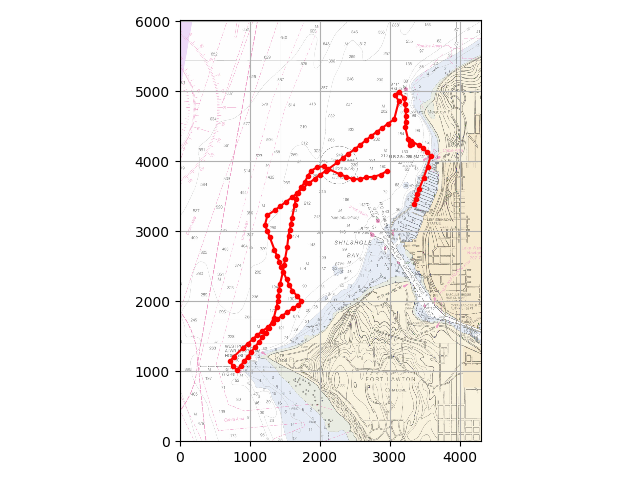

In [4]:
ch = c.plot_chart(df_creative)
c.draw_track(df_creative, ch, color='red', marker='.')

## Mostly There

Success!  Mostly.

First some observations.  This data is quite different from the race logs that are generated from the boat logs:

- There are only 4 "instruments": lat/lon/sog/cog
  - And currently sog/cog are ignore (see below)
- The rows are not generated at a synchronous fixed frequency.  Race logs are generated at 10Hz.  This data is processed so that rows are asynchronous, and are *event driven*.  There is one row per AIS message.

In fact this data is **very low frequency**.  There is approximately one row every 30 seconds (rather than 10 per second). Zooming into this data shows that this is just barely sufficient to show how the boat moves.  In particularly at the north "mark" the rounding is very coarse.

We can use COG/SOG to improve the quality of the track.  COG/SOG provides additional information about the track (speed and direction of travel).  From a mathematical standpoint these two numbers *double* the information that we have the track (rather than 2 observations we have 4).  COG/SOG are in fact the derivative of the track.

We can create a higher quality track by using the fitting a spline to the available data, and if we use a cubic spline we can include the derivatives as well.  The resulting smooth curve will fit the lat/lon coordinates **and** the COG/SOG.

<IPython.core.display.Javascript object>


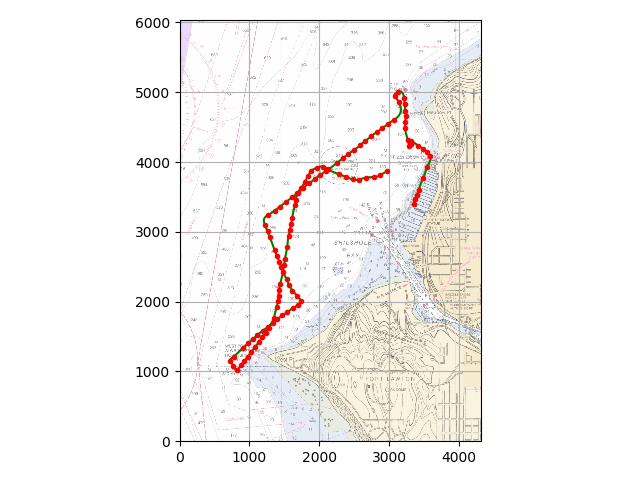

In [5]:
def fit_spline(df, plot=False):
    basetime = df.row_times.min()
    x = np.array((df.row_times - basetime) / pd.Timedelta('1s'))
    y = np.vstack(G.MAP(np.asarray(df.longitude), np.asarray(df.latitude))).T
    vog_latitude = df.sog * p.cos_d(df.cog)
    vog_longitude = df.sog * p.sin_d(df.cog)
    dy = np.vstack((vog_longitude, vog_latitude)).T
    ss = scipy.interpolate.CubicHermiteSpline(x, y, dy)
    x_new = np.linspace(x.min(), x.max(), int((x.max() - x.min())/5))
    ll = ss(x_new)
    lon_new, lat_new = G.MAP(ll[:,0], ll[:,1], inverse=True)
    datetime64 = np.datetime64(basetime.tz_convert('UTC').tz_localize(None))
    time_new = datetime64 + x_new * pd.Timedelta('1s')
    ndf = pd.DataFrame(dict(row_times=time_new, latitude = lat_new, longitude = lon_new))
    ndf.row_times = ndf.row_times.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
    ndf['altitude'] = 0
    if plot:
        ch = c.plot_chart(ndf)
        c.draw_track(ndf, ch)
        c.draw_track(df, ch, color='red', linestyle = 'None', marker='.')
    return ndf

sdf = fit_spline(df_creative, True)
      

### Finally

Finally some simple code to generate the GPX file (which can be uploaded to RaceQs).


In [6]:
def row_to_lla(index_row):
    _, row = index_row
    return dict(timestamp = arrow.get(row.row_times),
                lat = row.latitude,
                lon = row.longitude,
                alt = row.altitude)

def ais_df_to_gpx(df, gpx_file, skip=1):
    lla_rows = map(row_to_lla, it.islice(df.iterrows(), 0, None, skip))
    gpx = cb.lla_to_gpx(lla_rows)
    logging.info(f"Writing GPX result to {gpx_file}")
    with open(gpx_file, 'w') as gpx_fs:
        gpx_fs.write(gpx.to_xml())

ais_df_to_gpx(sdf, "/tmp/foo.gpx")
        

2020-04-14 22:10:15,317|INFO|ais_df_to_gpx| Writing GPX result to /tmp/foo.gpx
